In [0]:
#  https://www.kaggle.com/lpanda/netflix-data

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import dask.dataframe as dd # asynchronous load and subset which is useful for large dataset sampling
# from dask.distributed import Client

# # visualization
# import seaborn as sns
# import matplotlib.pyplot as plt
# sns.set(style="whitegrid", context='paper')
# sns.set(rc={'figure.figsize':(18,5)})

# from functools import wraps # a ditty decorator

# from sklearn.metrics.pairwise import cosine_similarity

import random # random integers
import os # i/o read files
import time # time my work
import gc  # clear ram

In [2]:
# Mount drive
import os
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/My Drive/Colab Notebooks/privacy'

print(os.listdir())

ModuleNotFoundError: No module named 'google.colab'

In [8]:
%load_ext autoreload
%autoreload 1

%aimport privacy

In [0]:
# !cat netflix-prize-data/combined_data_1.txt netflix-prize-data/combined_data_2.txt netflix-prize-data/combined_data_3.txt netflix-prize-data/combined_data_4.txt | python clean_data.py >> ratings.csv

In [10]:
# !head -n 10 ratings.csv

movieId,custId,rating,date
1,1488844,3,2005-09-06
1,822109,5,2005-05-13
1,885013,4,2005-10-19
1,30878,4,2005-12-26
1,823519,3,2004-05-03
1,893988,3,2005-11-17
1,124105,4,2004-08-05
1,1248029,3,2004-04-22
1,1842128,4,2004-05-09


In [4]:
df = pd.read_csv('ratings.csv', nrows = 100000, index_col = 1)
# df = pd.read_csv('ratings.csv', index_col = 1)

# iter_csv = pd.read_csv('file.csv', iterator=True, chunksize=1000)
# df = pd.concat([chunk[chunk['field'] > constant] for chunk in iter_csv]

In [5]:
df.index.max()

2649426

In [23]:
df.shape

(100480507, 3)

In [0]:
indices = df.index.value_counts()

In [12]:
len(indices.index)

480189

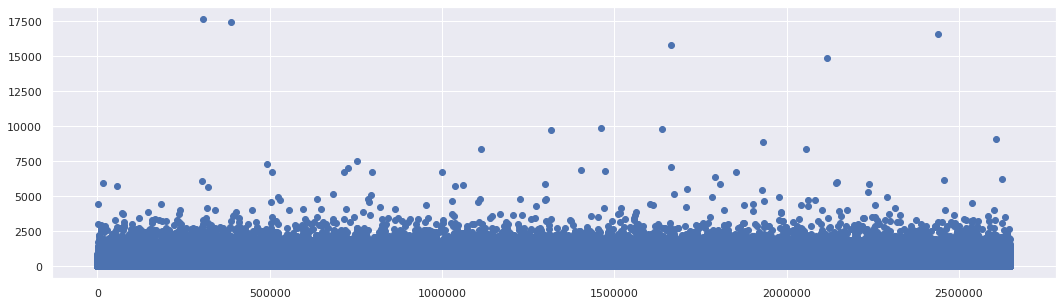

In [16]:
plt.scatter(indices.index, indices)

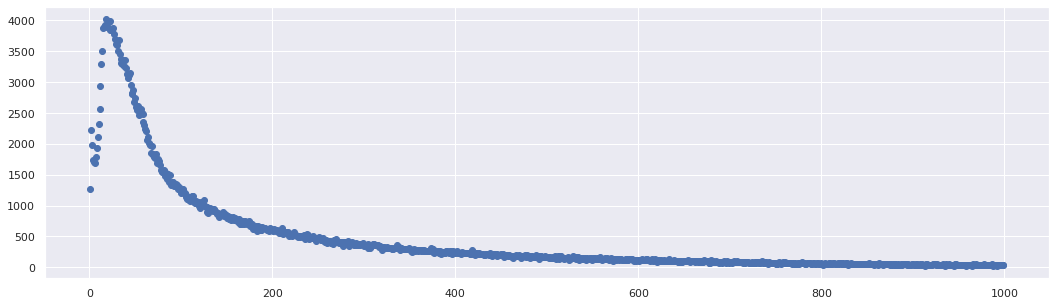

In [22]:
nb_reviews = indices.value_counts().sort_index()
plt.scatter(nb_reviews[nb_reviews.index<1000].index, nb_reviews[nb_reviews.index<1000])

In [9]:
print(df['date'].min())
print(df['date'].max())
MIN_DATE = '1999-11-11'
MAX_DATE = '2005-12-31'
print((pd.to_datetime(MAX_DATE) - pd.to_datetime(MIN_DATE)).days)

2000-01-06
2005-12-31
2242


In [115]:
df['days'] = (pd.to_datetime(df['date']) - pd.to_datetime(MIN_DATE)).dt.days
df = df.drop('date', axis=1)
df.head()

In [186]:
aux_list = [privacy.Auxiliary(True, True, 0, 0), privacy.Auxiliary(True, True, 0, 0)]

aux = privacy.Generate.generate(df, aux_list, custId=1488844)
aux

,movieId,rating,days
custId,,,
1488844,1,3,2126
1488844,8,4,2009


In [187]:
df.loc[1488844]

,movieId,rating,days
custId,,,
1488844,1,3,2126
1488844,8,4,2009
1488844,17,2,2057
1488844,30,3,1980


In [411]:
# scoring = privacy.Score_simple(privacy.equal_similarity)
# scoring = privacy.Scoreboard(privacy.equal_similarity, df)
# scoring = privacy.Scoreboard_RH(privacy.netflix_similarity(1.5,30), df)
scoring = privacy.Scoreboard_RH(privacy.general_similarity(), df)


# scoring.similarity(aux, df.loc[1488844])
scores = scoring.compute_score(aux, df)
scores

custId_2
1488844    0.525357
2239213    0.421297
2423091    0.317236
984369     0.317236
1025798    0.317236
             ...   
1731912    0.000000
1731944    0.000000
1731960    0.000000
1731996    0.000000
7          0.000000
Name: value, Length: 81490, dtype: float64

In [416]:
scoring.matching_set(scores, 0.5)
# scoring.output(scores, 0.5)

(custId_2
 1488844    0.525357
 Name: value, dtype: float64, 3.3419138301334903)

In [ ]:
# Test on similarities

In [417]:
cust1 = df.loc[[1488844]].set_index('movieId', drop=True)
cust2 = df.loc[[822109]].set_index('movieId', drop=True)

In [426]:
merged = pd.merge(cust1, cust2, how='outer', left_index=True, right_index=True, suffixes=('_1', '_2'))
merged

,rating_1,days_1,rating_2,days_2
movieId,,,,
1,3,2126,5.0,2010.0
8,4,2009,NaN,NaN
17,2,2057,NaN,NaN
30,3,1980,NaN,NaN


In [433]:
merged2 = merged.copy()
merged2.loc[1, 'rating_2']=4
merged2

,rating_1,days_1,rating_2,days_2
movieId,,,,
1,3,2126,4.0,2010.0
8,4,2009,NaN,NaN
17,2,2057,NaN,NaN
30,3,1980,NaN,NaN


In [432]:
privacy.netflix_similarity(r0=1.5, d0=30)(merged)
# privacy.general_similarity(2,14)(merged)

movieId
1     0.284525
8     0.000000
17    0.000000
30    0.000000
dtype: float64

In [434]:
privacy.netflix_similarity(r0=1.5, d0=30)(merged2)

movieId
1     0.534345
8     0.000000
17    0.000000
30    0.000000
dtype: float64

In [431]:
privacy.netflix_similarity_old(r0=1.5, d0=30)(merged)

movieId
1     48.046441
8      0.000000
17     0.000000
30     0.000000
dtype: float64